# Per-state LSTM regression model ensemble

New plan - run the LSTM in regression mode on the incidents. Hopefully it will perform better and we can do autoregressive future predictions since we are predicting the input for the next time step. If we want a binary output we can tune a threshold on incidents.

## Notebook set-up

In [1]:
# Standard library imports
import os
import multiprocessing as mp

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve

# Internal imports
import perdrizet_helper_funcs

# Set GPU for TensorFlow
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Set multiprocessing start method to allow CUDA use in the workers
mp.set_start_method('spawn')

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

# Incident feature to use
incident_feature='log_incidents'

# Training details
model_type='regression'
include_synthetic_features=False
retrain_ensemble=True
window=18
num_training_workers=5
training_epochs=100
learning_rate=0.01
l1_weight=0.01
l2_weight=0.1

## 1. Data loading

In [2]:
raw_data_df=pd.read_parquet(data_file)

# Grab the features we are interested in
data_df=raw_data_df[['month_cos', 'month_sin', incident_feature]].copy()

# Transfer the index
data_df.set_index(raw_data_df.index)

# Save the index of the target column
target_column_index=data_df.columns.get_loc(incident_feature)
data_df.head()

month_cos     month_sin  log_incidents
year month state                                           
1953 5     LA    -8.660254e-01  5.000000e-01            1.0
     6     LA    -1.000000e+00  1.224647e-16            0.0
     7     LA    -8.660254e-01 -5.000000e-01            0.0
     8     LA    -5.000000e-01 -8.660254e-01            0.0
     9     LA    -1.836970e-16 -1.000000e+00            0.0

In [3]:
data_df.describe()

,month_cos,month_sin,log_incidents
count,3.762200e+04,3.762200e+04,37622.000000
mean,-4.561229e-04,-7.174095e-04,0.067273
std,7.072053e-01,7.070265e-01,0.286450
min,-1.000000e+00,-1.000000e+00,0.000000
25%,-8.660254e-01,-8.660254e-01,0.000000
50%,-1.836970e-16,-2.449294e-16,0.000000
75%,5.000000e-01,5.000000e-01,0.000000
max,1.000000e+00,1.000000e+00,2.706718


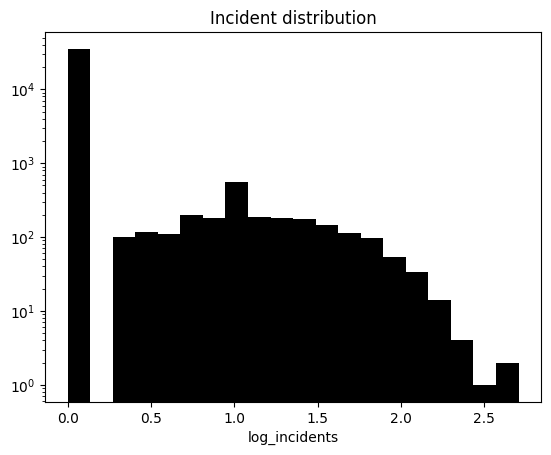

In [4]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Incident distribution')
plt.hist(data_df[incident_feature], bins=20, color='black')
plt.xlabel(incident_feature)
plt.yscale('log')
plt.savefig('./figures/5.2-1-regression_state_LSTM_incident_distribution.jpg')
plt.show()

## 2. Train-test split

Take the most recent ~10% of the data for testing.

In [5]:
# Get list of years
years=data_df.index.get_level_values('year').unique().tolist()
testing_years=len(years) // 10
print(f'Using most recent {testing_years} of {len(years)} years for test set')
print(f'Testing years: {years[-testing_years:]}')
print(f'Training years: {years[:-testing_years]}')

# Take last n years for testing data
testing_df=data_df.loc[years[-testing_years:]]

# Take the rest for training
training_df=data_df.loc[years[:-testing_years]]

# Check result
training_df.head()

Using most recent 7 of 71 years for test set
Testing years: [2017, 2018, 2019, 2020, 2021, 2022, 2023]
Training years: [1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


month_cos     month_sin  log_incidents
year month state                                           
1953 5     LA    -8.660254e-01  5.000000e-01            1.0
     6     LA    -1.000000e+00  1.224647e-16            0.0
     7     LA    -8.660254e-01 -5.000000e-01            0.0
     8     LA    -5.000000e-01 -8.660254e-01            0.0
     9     LA    -1.836970e-16 -1.000000e+00            0.0

In [6]:
training_df.describe()

,month_cos,month_sin,log_incidents
count,3.481300e+04,3.481300e+04,34813.000000
mean,3.965142e-04,-3.022706e-03,0.063086
std,7.073504e-01,7.068768e-01,0.275817
min,-1.000000e+00,-1.000000e+00,0.000000
25%,-5.000000e-01,-8.660254e-01,0.000000
50%,-1.836970e-16,-2.449294e-16,0.000000
75%,8.660254e-01,5.000000e-01,0.000000
max,1.000000e+00,1.000000e+00,2.706718


## 3. Data formatting & training-validation splitting

In [7]:
# Run custom splitting function
training_features, training_labels, validation_features, validation_labels, states=perdrizet_helper_funcs.make_windowed_time_course(training_df, target_column_index, window)

# Check the result
print(f'States: {len(training_features)}')

for state, features, labels in zip(states, training_features, training_labels):
    print(f'{state}: features: {features.shape}, labels: {labels.shape}')

States: 50
LA: features: (515, 18, 3), labels: (515, 1)
MT: features: (515, 18, 3), labels: (515, 1)
TX: features: (515, 18, 3), labels: (515, 1)
IA: features: (515, 18, 3), labels: (515, 1)
FL: features: (512, 18, 3), labels: (512, 1)
CA: features: (509, 18, 3), labels: (509, 1)
SD: features: (506, 18, 3), labels: (506, 1)
WV: features: (505, 18, 3), labels: (505, 1)
ME: features: (504, 18, 3), labels: (504, 1)
MA: features: (504, 18, 3), labels: (504, 1)
CT: features: (504, 18, 3), labels: (504, 1)
RI: features: (504, 18, 3), labels: (504, 1)
SC: features: (503, 18, 3), labels: (503, 1)
NY: features: (503, 18, 3), labels: (503, 1)
IN: features: (503, 18, 3), labels: (503, 1)
NM: features: (503, 18, 3), labels: (503, 1)
NC: features: (503, 18, 3), labels: (503, 1)
CO: features: (485, 18, 3), labels: (485, 1)
NV: features: (498, 18, 3), labels: (498, 1)
OK: features: (498, 18, 3), labels: (498, 1)
NJ: features: (496, 18, 3), labels: (496, 1)
PA: features: (496, 18, 3), labels: (496, 1)

## 4. Model training

### 4.1. Set-up and build models

In [8]:
if retrain_ensemble:
    
    model_builder=mp.Process(
        target=perdrizet_helper_funcs.make_state_models,
        args=(
            states,
            training_features,
            learning_rate,
            l1_weight,
            l2_weight,
            'regression'
        ))

    model_builder.start()
    model_builder.join()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): set_memory_growth==True
Compiling LSTM for state ensemble with L1=0.01, L2=0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 512)               1056768   
                                                                 
 dense.1 (Dense)             (None, 256)               131328    
                                                                 
 dense.2 (Dense)             (None, 128)               32896     
                                                                 
 dense.3 (Dense)             (None, 32)                4128      
                                                                 
 regression_output (Dense)   (None, 1)                 33        
                                                                 
Total params: 1,225,153
Trainable params: 1

### 4.2. Train the model ensemble

In [9]:
def run_training_workers(n: int):
    '''Runs n training workers to train each state model.'''

    # Set-up multiprocessing queues for input to workers
    mp_manager=mp.Manager()
    input_queue=mp_manager.Queue(-1)

    # Set-up training worker processes
    training_workers=[]
    for _ in range(n):
        training_workers.append(
            mp.Process(
                target=perdrizet_helper_funcs.state_training_run,
                args=(
                    input_queue,
                    training_epochs,
                    'regression'
                )
            )
        )

    # Start the training workers
    for worker in training_workers:
        worker.start()

    # Put the work in the input queue
    for i in range(len(training_features)):

        # Build the workunit
        workunit={
            'status': 'Work',
            'state': states[i],
            'training_features': training_features[i],
            'training_labels': training_labels[i],
            'validation_features': validation_features[i],
            'validation_labels': validation_labels[i]
        }

        # Submit the workunit
        input_queue.put(workunit)

    # Send a stop signal for each worker
    for _ in range(n):
        input_queue.put({'status': 'Done'})

    # Join and then close each score training process
    for worker in training_workers:
        worker.join()
        worker.close()

In [10]:
%%time

if retrain_ensemble:
    run_training_workers(num_training_workers)

CPU times: user 35.7 ms, sys: 78.7 ms, total: 114 ms
Wall time: 6min 8s


### 4.2. Plot training curves

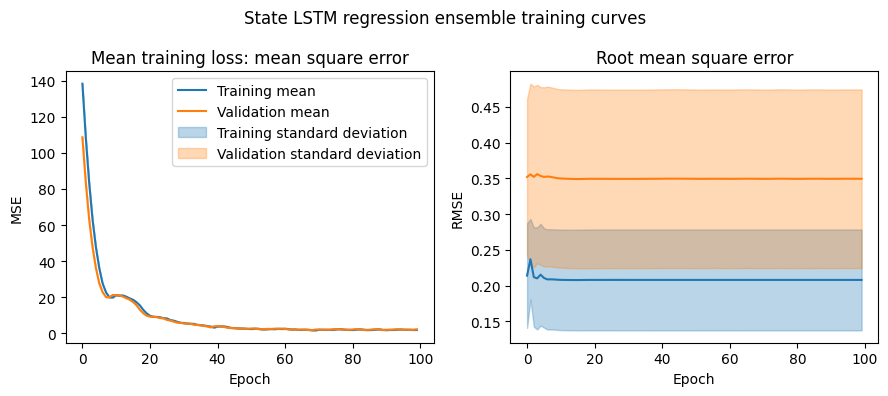

In [11]:
plot=perdrizet_helper_funcs.plot_regression_ensemble_training_run(states)
plot.savefig('./figures/5.2-4.2-regression_state_LSTM_ensemble_training_curves.jpg')
plot.show()

## 5. Model evaluation

### 5.1. Make predictions on test set

#### 5.1.1. Format testing data for prediction

In [12]:
testing_features=[]
testing_labels=[]

states=testing_df.index.get_level_values('state').unique().tolist()

for state in states:

    state_df=testing_df.loc[:,:,(state)].copy()

    if len(state_df) > window + 1:

        state_testing_features=[]
        state_testing_labels=[]

        for i in range(len(state_df) - window -  1):

            state_testing_features.append(state_df.iloc[i:i + window])
            state_testing_labels.append([state_df.iloc[window + i + 1,target_column_index]])

        testing_features.append(np.array(state_testing_features))
        testing_labels.append(np.array(state_testing_labels))

# Check the result
for state, features, labels in zip(states, testing_features, testing_labels):
    print(f'{state}: features: {features.shape}, labels: {labels.shape}')

LA: features: (38, 18, 3), labels: (38, 1)
MT: features: (47, 18, 3), labels: (47, 1)
TX: features: (31, 18, 3), labels: (31, 1)
IA: features: (41, 18, 3), labels: (41, 1)
FL: features: (52, 18, 3), labels: (52, 1)
CA: features: (56, 18, 3), labels: (56, 1)
SD: features: (47, 18, 3), labels: (47, 1)
WV: features: (49, 18, 3), labels: (49, 1)
ME: features: (53, 18, 3), labels: (53, 1)
MA: features: (42, 18, 3), labels: (42, 1)
CT: features: (38, 18, 3), labels: (38, 1)
RI: features: (42, 18, 3), labels: (42, 1)
SC: features: (50, 18, 3), labels: (50, 1)
NY: features: (53, 18, 3), labels: (53, 1)
IN: features: (50, 18, 3), labels: (50, 1)
NM: features: (53, 18, 3), labels: (53, 1)
NC: features: (38, 18, 3), labels: (38, 1)
NV: features: (37, 18, 3), labels: (37, 1)
OK: features: (31, 18, 3), labels: (31, 1)
NJ: features: (52, 18, 3), labels: (52, 1)
PA: features: (30, 18, 3), labels: (30, 1)
OR: features: (50, 18, 3), labels: (50, 1)
WA: features: (48, 18, 3), labels: (48, 1)
ID: feature

#### 5.1.2. Make predictions for each state

In [13]:
with mp.Manager() as manager:
    results=manager.list()

    for state, state_features, in zip(states, testing_features):
        print(f'Making predictions for {state} testing data.')
        inference_worker=mp.Process(
            target=perdrizet_helper_funcs.make_state_predictions,
            args=(
                state,
                state_features,
                results,
                'regression'
            )
        )

        inference_worker.start()
        inference_worker.join()

    # Collect the results back into a python list
    predictions=list(results)

Making predictions for LA testing data.
Making predictions for MT testing data.
Making predictions for TX testing data.
Making predictions for IA testing data.
Making predictions for FL testing data.
Making predictions for CA testing data.
Making predictions for SD testing data.
Making predictions for WV testing data.
Making predictions for ME testing data.
Making predictions for MA testing data.
Making predictions for CT testing data.
Making predictions for RI testing data.
Making predictions for SC testing data.
Making predictions for NY testing data.
Making predictions for IN testing data.
Making predictions for NM testing data.
Making predictions for NC testing data.
Making predictions for NV testing data.
Making predictions for OK testing data.
Making predictions for NJ testing data.
Making predictions for PA testing data.
Making predictions for OR testing data.
Making predictions for WA testing data.
Making predictions for ID testing data.
Making predictions for PR testing data.


#### 5.1.2. Combine and format predictions

In [14]:
prediction_dfs=[]
scaler=MinMaxScaler()

for state, state_predictions, state_labels in zip(states, predictions, testing_labels):
    if len(state_predictions) > 0:
        prediction_df=pd.DataFrame.from_dict(
            {
                'Incidents': np.array(state_labels).flatten(),
                'Predicted incidents': np.array(state_predictions).flatten(),
                'Binary labels': np.where(state_labels > 0, 1, state_labels).flatten().astype(int)
            }
        )
        prediction_df['state']=[state]*len(prediction_df)
        prediction_dfs.append(prediction_df)

predictions_df=pd.concat(prediction_dfs)
predictions_df.head()

,Incidents,Predicted incidents,Binary labels,state
0,0.0,0.064289,0,LA
1,0.0,0.064289,0,LA
2,0.0,0.064290,0,LA
3,0.0,0.064290,0,LA
4,0.0,0.064290,0,LA


In [15]:
predictions_df.describe()

,Incidents,Predicted incidents,Binary labels
count,1922.000000,1922.000000,1922.000000
mean,0.132598,0.043565,0.106139
std,0.416454,0.020678,0.308096
min,0.000000,0.006438,0.000000
25%,0.000000,0.023491,0.000000
50%,0.000000,0.048110,0.000000
75%,0.000000,0.057568,0.000000
max,2.705864,0.092898,1.000000


### 5.2. Correlation of predicted and true incidents

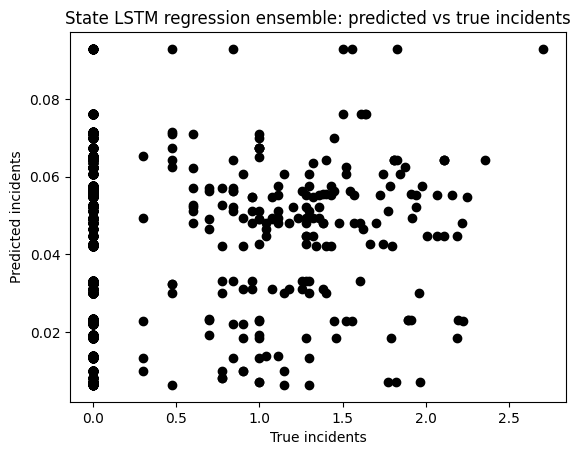

In [16]:
plt.title('State LSTM regression ensemble: predicted vs true incidents')
plt.scatter(predictions_df['Incidents'], predictions_df['Predicted incidents'], color='black')
plt.xlabel('True incidents')
plt.ylabel('Predicted incidents')
plt.savefig('./figures/5.2-5.2-regression_state_LSTM_ensemble_incident_predictions.jpg', dpi=300)
plt.show()

### 5.3. Distribution of predicted incident probabilities

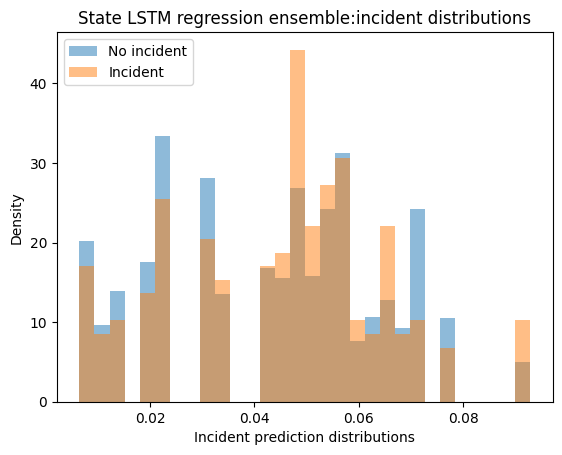

In [17]:
plt.title('State LSTM regression ensemble:incident distributions')
plt.hist(predictions_df['Predicted incidents'][predictions_df['Binary labels'] == 0], bins=30, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['Predicted incidents'][predictions_df['Binary labels'] == 1], bins=30, density=True, alpha=0.5, label='Incident')
plt.xlabel('Incident prediction distributions')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.savefig('./figures/5.2-5.3-regression_state_LSTM_ensemble_incident_distributions.jpg', dpi=300)
plt.show()

### 5.4. Receiver-operator characteristic and precision-recall curves

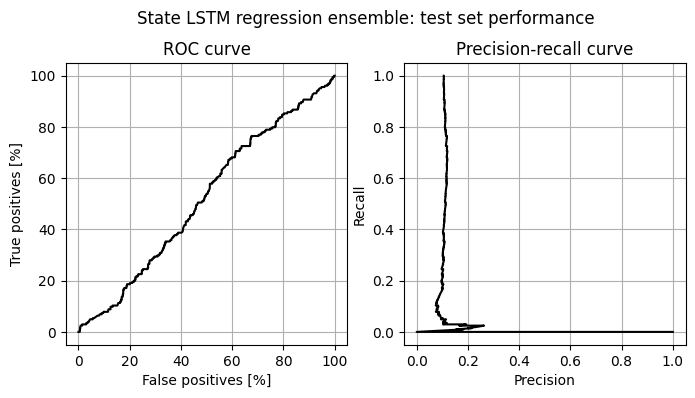

In [18]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('State LSTM regression ensemble: test set performance', size='large')

# Plot ROC curve
fp, tp, _=roc_curve(predictions_df['Binary labels'], predictions_df['Predicted incidents'])
axs[0].set_title('ROC curve')
axs[0].plot(100*fp, 100*tp, color='black')
axs[0].set_xlabel('False positives [%]')
axs[0].set_ylabel('True positives [%]')
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot PR curve
precision, recall, _=precision_recall_curve(predictions_df['Binary labels'], predictions_df['Predicted incidents'])
axs[1].set_title('Precision-recall curve')
axs[1].plot(precision, recall, color='black')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.savefig('./figures/5.2-5.4-regression_state_LSTM_ensemble_ROC_PR_curves.jpg', dpi=300)
plt.show()

### 5.5. Confusion matrix

Precision: 0.118
Recall: 0.681



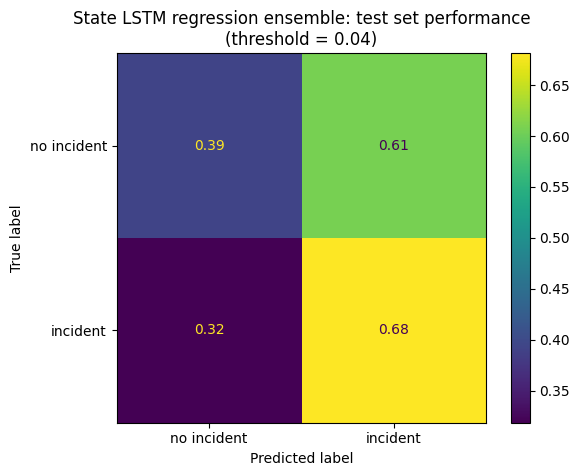

In [19]:
# Set threshold and call incidents
threshold=0.04
calls=np.where(predictions_df['Predicted incidents'] > threshold, 1, 0)

# Calculate precision and recall
precision=precision_score(predictions_df['Binary labels'], calls)
recall=recall_score(predictions_df['Binary labels'], calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(predictions_df['Binary labels'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no incident', 'incident'])
_=cm_disp.plot()
plt.title(f'State LSTM regression ensemble: test set performance\n(threshold = {threshold})')
plt.savefig('./figures/5.2-5.5-regression_state_LSTM_ensemble_confusion_matrix.jpg', dpi=300)
plt.show()